# A/A-тест

## Настройки

In [1]:
import pandahouse
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns

In [2]:
# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(15,10)})

In [3]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230720'
}

## Задача

При проведении А/А-теста было бы здорово убедиться в том, что наша система сплитования работает корректно, и ключевая метрика не отличается между группами не только в конкретно нашем А/А-тесте, но и в целом.

В идеале было бы здорово провести бесконечное количество А/A-тестов и посмотреть, в каком количестве случаев нам удалось отклонить нулевую гипотезу. Если система сплитования работает корректно, то статистически значимые различия между двумя группами встречались бы только в результате случайного ложного срабатывания. Например, если мы отвергаем нулевую гипотезу при условии, что p_value < 0.05, то только приблизительно в 5% случаев у нас бы получались статистические значимые различия между 0 и 1 группой.

Мы будем многократно извлекать подвыборки из наших данных, проводить t-test, а в конце посмотрим, в каком проценте случаев нам удалось отклонить нулевую гипотезу.

## Задача
* У нас есть данные А/А-теста с '2023-06-23' по '2023-06-29'. Нужно сделать симуляцию, как будто мы провели 10000 А/А-тестов.
* На каждой итерации нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы.
* Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.
2. Посчитать, какой процент p values оказался меньше либо равен 0.05
3. Написать вывод по проведенному А/А-тесту, корректно ли работает наша система сплитования.
4. Пришлите ссылку на merge request c проведенным анализом.

## Решение

In [4]:
%%time
# У нас есть данные А/А-теста с  '2023-06-23' по '2023-06-29'
q = """
SELECT 
    exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-06-23' and '2023-06-29'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

CPU times: user 74.1 ms, sys: 6.27 ms, total: 80.3 ms
Wall time: 636 ms


In [5]:
# сколько пользователей в группах
df.groupby('exp_group').agg({'user_id': 'count'})

,user_id
exp_group,
2,8362
3,8425


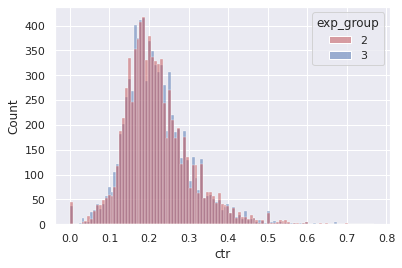

In [6]:
# Посмотрим распределения CTR в группах 2 и 3
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [7]:
%%time
# Нужно сделать симуляцию, как будто мы провели 10000 А/А-тестов.
# На каждой итерации нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы.
n_samples = 10000  # количество выборок для t-тестов
p_values = []  # список, в который будем складывать полученные по результатам t-теста p-values
for _ in range(n_samples):
    df_gr2 = df[df['exp_group'] == 2].sample(n=500, replace=False)  # n=500 - кол-во пользователей , replace=False - без повторения
    df_gr3 = df[df['exp_group'] == 3].sample(n=500, replace=False)
    p_value = stats.ttest_ind(df_gr2['ctr'],
                              df_gr3['ctr'],
                              equal_var=False)[1]
    p_values.append(p_value)

p_values = np.array(p_values)

CPU times: user 1min 3s, sys: 0 ns, total: 1min 3s
Wall time: 1min 3s


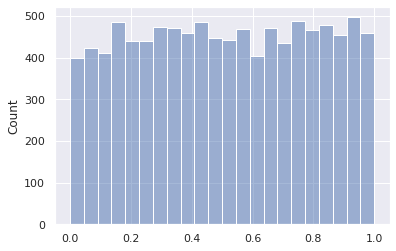

In [8]:
# Построить гистограмму распределения получившихся 10000 p-values.
p_values_hist = sns.histplot(data = p_values, 
                             alpha=0.5,
                             kde=False)

In [9]:
len(p_values)

10000

In [10]:
# Посчитать, какой процент p values оказался меньше либо равен 0.05
# доля p_value, значения которых меньше либо равен 0.05
len(p_values[p_values <= 0.05]) / len(p_values)

0.0425

In [11]:
1 - 0.0425

0.9575

## Выводы

1. Доля p_value, значения которых меньше либо равен 0,05 составила 4,25%
2. Выбранная система разбиения пользователей на подгруппы работает корректно: в большинстве случаев (95,75%) мы не наблюдаем значимых разлий в средних значениях CTR.


https://git.lab.karpov.courses/practice-da/analyst_simulator/-/merge_requests/998